### Generare le istanze

Prima assicurati di avere tutti i pachetti necessari installati. Se non hai installato i pacchetti, esegui il comando seguente: 
```bash
pip3 install -r requirements.txt
```

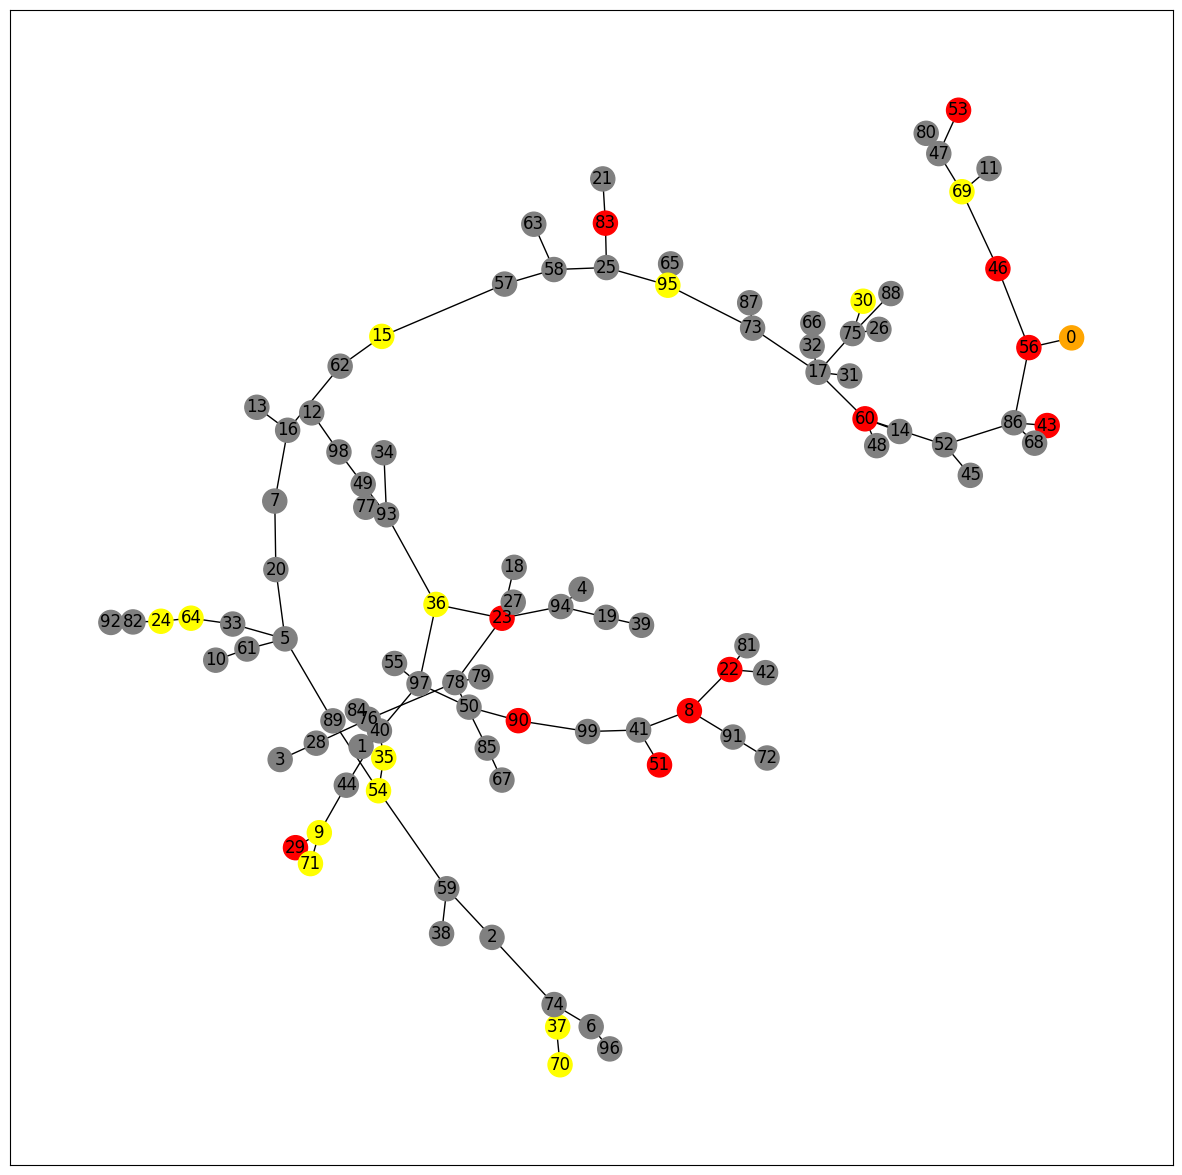

Is a tree: True
Number of edges:  99
Weight of the edges of the tree:  {(0, 56): 72.91776189653656, (1, 40): 122.78843593759146, (2, 74): 55.57877292636101, (2, 59): 146.98639392814562, (3, 28): 133.5440002396214, (4, 94): 227.80035118497952, (5, 61): 152.81688388394784, (5, 33): 102.00490184299969, (5, 20): 169.38713056191725, (5, 89): 118.68024266911489, (6, 96): 165.42369842317032, (6, 74): 138.23530663329106, (7, 16): 116.40017182117903, (7, 20): 140.2640367307315, (8, 22): 76.55716818169282, (8, 91): 83.93449827097318, (8, 41): 122.44182292011173, (9, 29): 106.89246933250256, (9, 71): 147.14618581533128, (9, 44): 87.84645695758026, (10, 61): 133.9589489358587, (11, 69): 102.45974819410792, (12, 98): 60.21627686929839, (13, 16): 114.9826073804208, (14, 60): 75.95393340703298, (15, 57): 28.231188426986208, (15, 62): 182.3869512876401, (16, 62): 74.54528824815154, (17, 31): 63.788713735268246, (17, 32): 102.1077861869505, (17, 60): 139.00359707575916, (17, 75): 102.42070103255493, (1

In [19]:
import networkx as nx
import utility_functions as uf

# CREATING A TREE NETWORK WITH 3 FLOWS AND 150 AUTONOMY

N = 100 #number of nodes
K = 15 #number of flows
L = 150 #autonomy of the vehicles
edge_dim = 200 #dimension of the edges



T = uf.generate_random_network_tree(N, K, L, edge_dim)
flows = uf.get_random_flows(T, K)

# save the tree and the flows
uf.save_tree(T, flows, "tree_net/bigtree.gml")

uf.draw_tree(T, flows)

print(f'Is a tree: {nx.is_tree(T)}')
print("Number of edges: ", T.number_of_edges())
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Number of nodes: ", T.number_of_nodes())
print("Number of flows: ", T.graph['K'])
print("Flows with their source and destination:", flows)

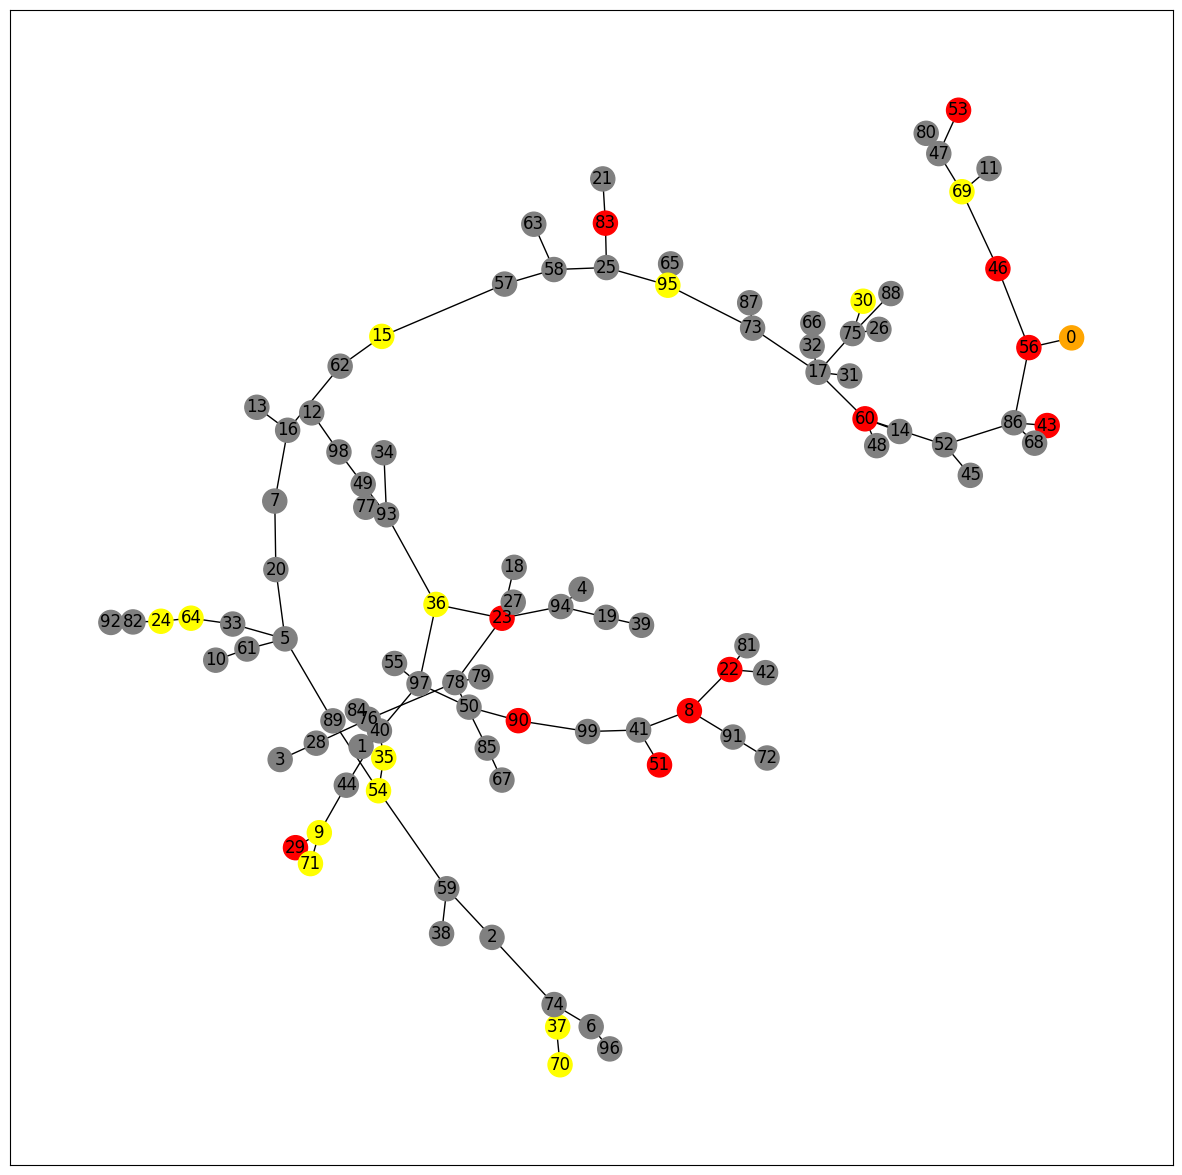

In [20]:
import networkx as nx
import utility_functions as uf

# READING THE TREE NETWORK FROM THE .gml FILE 
path_tree = "tree_net/bigtree.gml"
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")
uf.draw_tree(T, flows)

### Prima greedy naive

1. Iniziamo con un insieme vuoto di stazioni di ricarica.
2. Per ogni flusso da origine a destinazione, seguiamo il percorso dell'albero, che è unico. Ogni veicolo (flusso) parte con autonomia L.
3. Mentre percorriamo il percorso, diminuiamo l'autonomia del veicolo della lunghezza dell'arco che si percorre.
4. Se l'autonommia non è sufficiente per percorrere il prossimo arco del percorso, quindi percorrendolo scenderebbe a zero o meno, posizioniamo una colonnina di ricarica sul nodo corrente.
5. Ripetiamo i passaggi 3-4 fino a quando tutti i veicoli hanno raggiunto le loro destinazioni.

Questa euristica cerca di minimizzare il numero di stazioni di ricarica posizionando ogni stazione il più lontano possibile lungo ogni percorso, dato che ogni veicolo parte con la carica completa e ogni stazione di ricarica ricarica completamente la batteria del veicolo.

Flows with their source and destination: [['53', '69'], ['56', '9'], ['60', '15'], ['23', '37'], ['8', '36'], ['51', '64'], ['83', '71'], ['29', '35'], ['22', '30'], ['90', '37'], ['0', '70'], ['43', '54'], ['83', '0'], ['46', '95'], ['56', '24']]
Paths (a path for each flow): [['53', '47', '69'], ['56', '86', '52', '60', '17', '73', '95', '25', '58', '57', '15', '62', '16', '7', '20', '5', '89', '54', '35', '40', '44', '9'], ['60', '17', '73', '95', '25', '58', '57', '15'], ['23', '36', '97', '40', '35', '54', '59', '2', '74', '37'], ['8', '41', '99', '90', '50', '97', '36'], ['51', '41', '99', '90', '50', '97', '40', '35', '54', '89', '5', '33', '64'], ['83', '25', '58', '57', '15', '62', '16', '7', '20', '5', '89', '54', '35', '40', '44', '9', '71'], ['29', '9', '44', '40', '35'], ['22', '8', '41', '99', '90', '50', '97', '40', '35', '54', '89', '5', '20', '7', '16', '62', '15', '57', '58', '25', '95', '73', '17', '75', '30'], ['90', '50', '97', '40', '35', '54', '59', '2', '74', '3

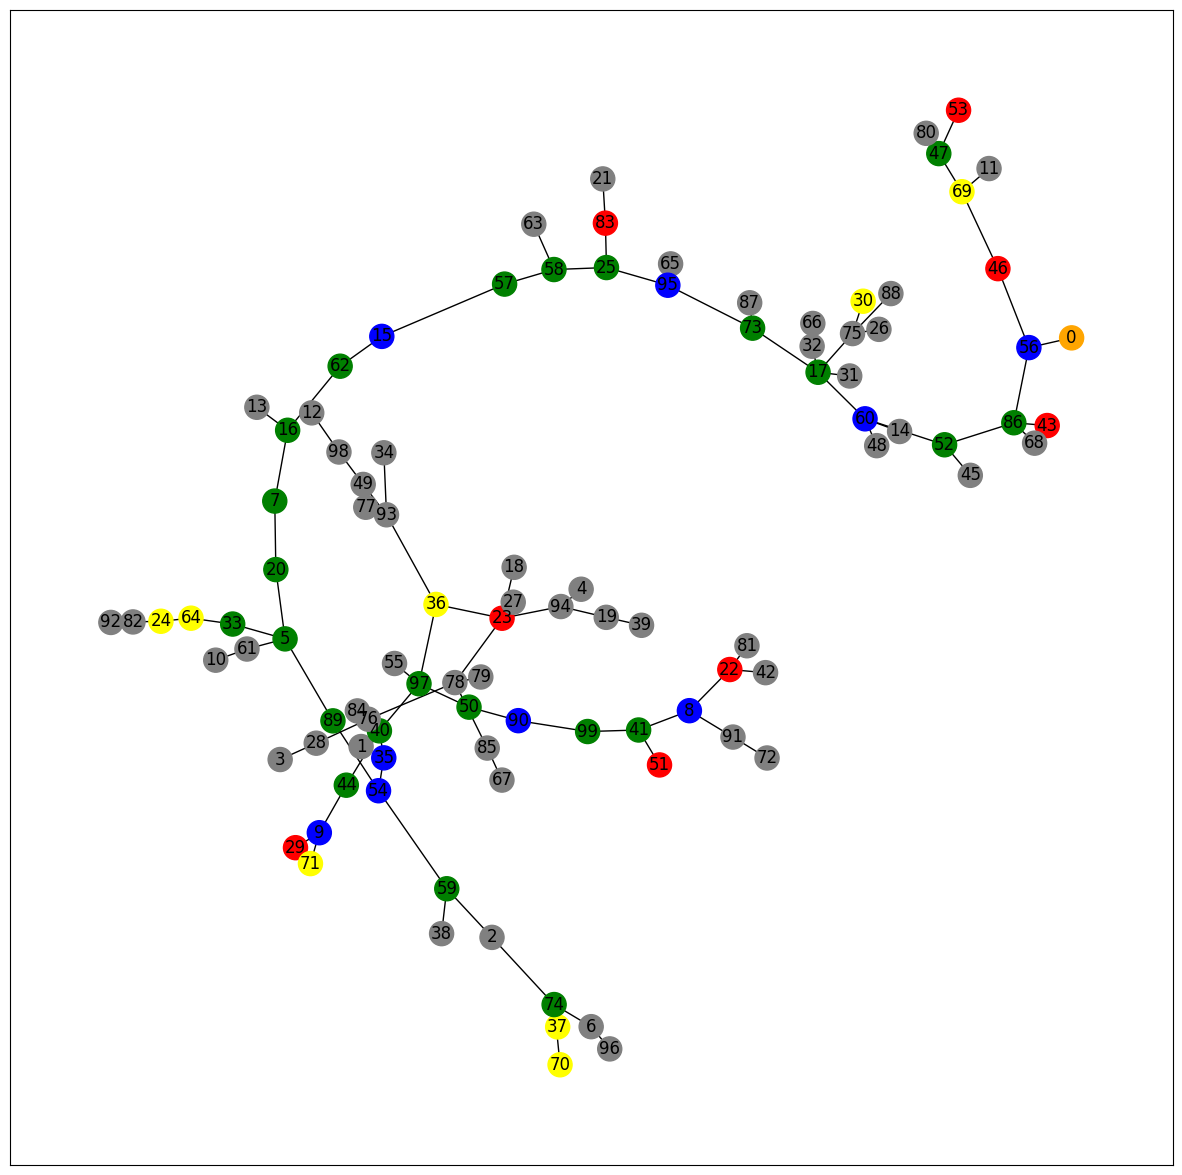

In [21]:
import networkx as nx
import utility_functions as uf

# load all necessaries data
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def greedy_electric_charging(Tree: nx.Graph, flows: list, L: int):
    charging_stations = set()
    paths = uf.get_all_paths_of_all_flows(Tree, flows)
    for path in paths:
        charge = L
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                Tree.nodes[path[i]]['chrg_station'] = True
                charge = L
    return paths, charging_stations

paths, charging_stations = greedy_electric_charging(T, flows, L)

print("Flows with their source and destination:", flows)
print(f'Paths (a path for each flow): {paths}')
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Charging stations on nodes:", (charging_stations))

print(f"COST: (number of charging stations): {len(charging_stations)}")

uf.draw_tree(T, flows)


### Greedy con intersezione tra i flussi

1. Si percorre il flusso da sorgente a destinazione e poi da destinazione a sorgente utilizzando l'algoritmo greedy naive sopra descritto. In questo modo otteniamo, per ogni flow, due possibili modi ammissibili di posizionare le stazioni di ricarica.

2. Si generano tutte le possibili combinazioni di set di stazioni di ricarica per ogni flusso.

3. Per ogni possibile combinazione di posizionamenti di stazioni di ricarica, se ne calcola l'unione. L'unione rappresenta il totale delle colonnine e quindi il costo.

4. Si vuole minimizzare il costo, per cui si sceglie la combinazione di set che minimizza l'unione.

COST: (number of charging stations): 23


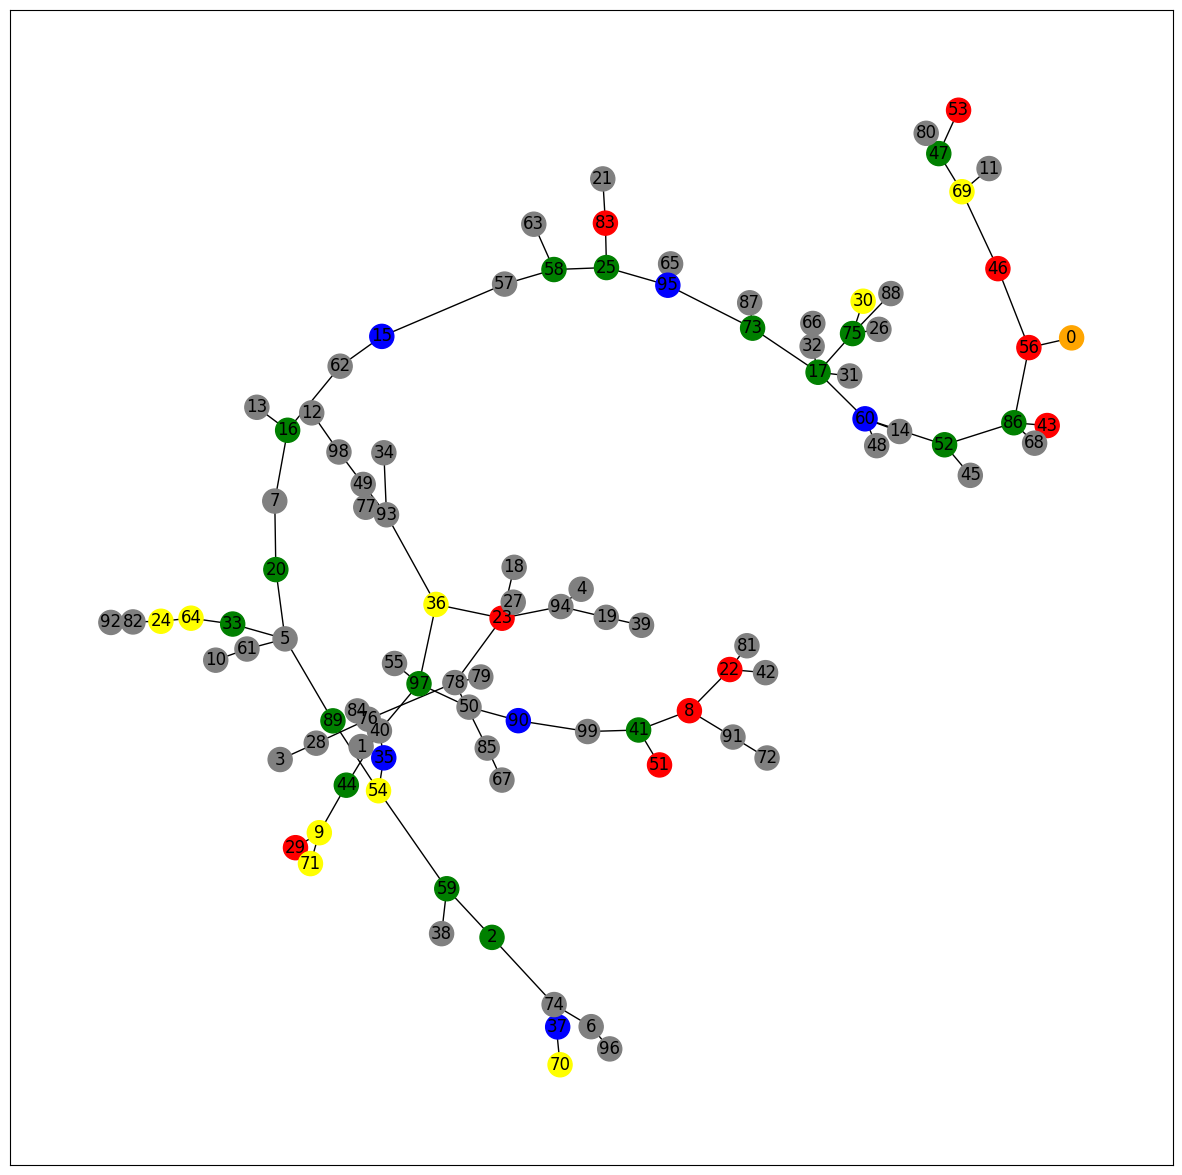

In [22]:
import itertools
import networkx as nx
import utility_functions as uf

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def possible_sets(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns two sets of charging stations for each flow, one for the forward path and one for the backward path.
    The dictionary has the following structure:
    {
        (flow1): [set11, set12],
        (flow2): [set21, set22],
        ...
    }
    '''
    charging_stations = {}
    paths_forward = uf.get_all_paths_of_all_flows(Tree, flows)
    paths_backward = [path[::-1] for path in paths_forward]

    for flow, path in zip(flows, paths_forward):
        charge = L
        charging_stations[tuple(flow)] = [set(), set()]  # Initialize with two empty sets
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations[tuple(flow)][0].add(path[i])  # Add to the first set
                charge = L
    
    for flow, path in zip(flows, paths_backward):
        charge = L
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations[tuple(flow)][1].add(path[i])  # Add to the second set
                charge = L

    return charging_stations

def generate_collections(flows):
    '''
    Generates all possible combinations of sets (cartesian product of the sets of charging stations for each flow)
    '''
    flow_sets = list(flows.values())
    combinations = list(itertools.product(*flow_sets))

    return combinations

def minimize_cost(possible_collections: list):
    '''
    Minimize the cost of the charging stations
    '''
    unions = [set.union(*collection) for collection in possible_collections]
    return min(unions, key=len)


flows_with_sets = possible_sets(T, flows, L)

possible_collections = generate_collections(flows_with_sets)

charging_stations = minimize_cost(possible_collections)
#print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")

uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)




### Greedy forward

Viene scelto il primo flusso da considerare in base alla lunghezza (prima il più lungo, ha con ogni probabilità più colonnine da posizionare).
Viene scelto il primo set per il primo flusso nella maniera forward. Per i successivi flussi, si utilizza sempre l'algoritmo greedy forward ma si tengono in considerazione le colonnine già posizionate per i flussi precedenti.

1. Si seleziona il flusso con path maggiore
2. Si inizializza un insieme di charging stations per tale flusso con l'algoritmo forward
3. Per i successivi flussi ordinati senso descrescente, si utilizza lo stesso algoritmo tenendo in considerazione le colonnine già posizionate per i flussi precedenti

Charging stations on nodes: {'47', '44', '59', '5', '95', '73', '33', '57', '25', '97', '54', '74', '16', '40', '62', '90', '99', '89', '9', '50', '41', '2', '58', '60', '20', '8', '17', '35', '15', '7', '86'}
COST: (number of charging stations): 31


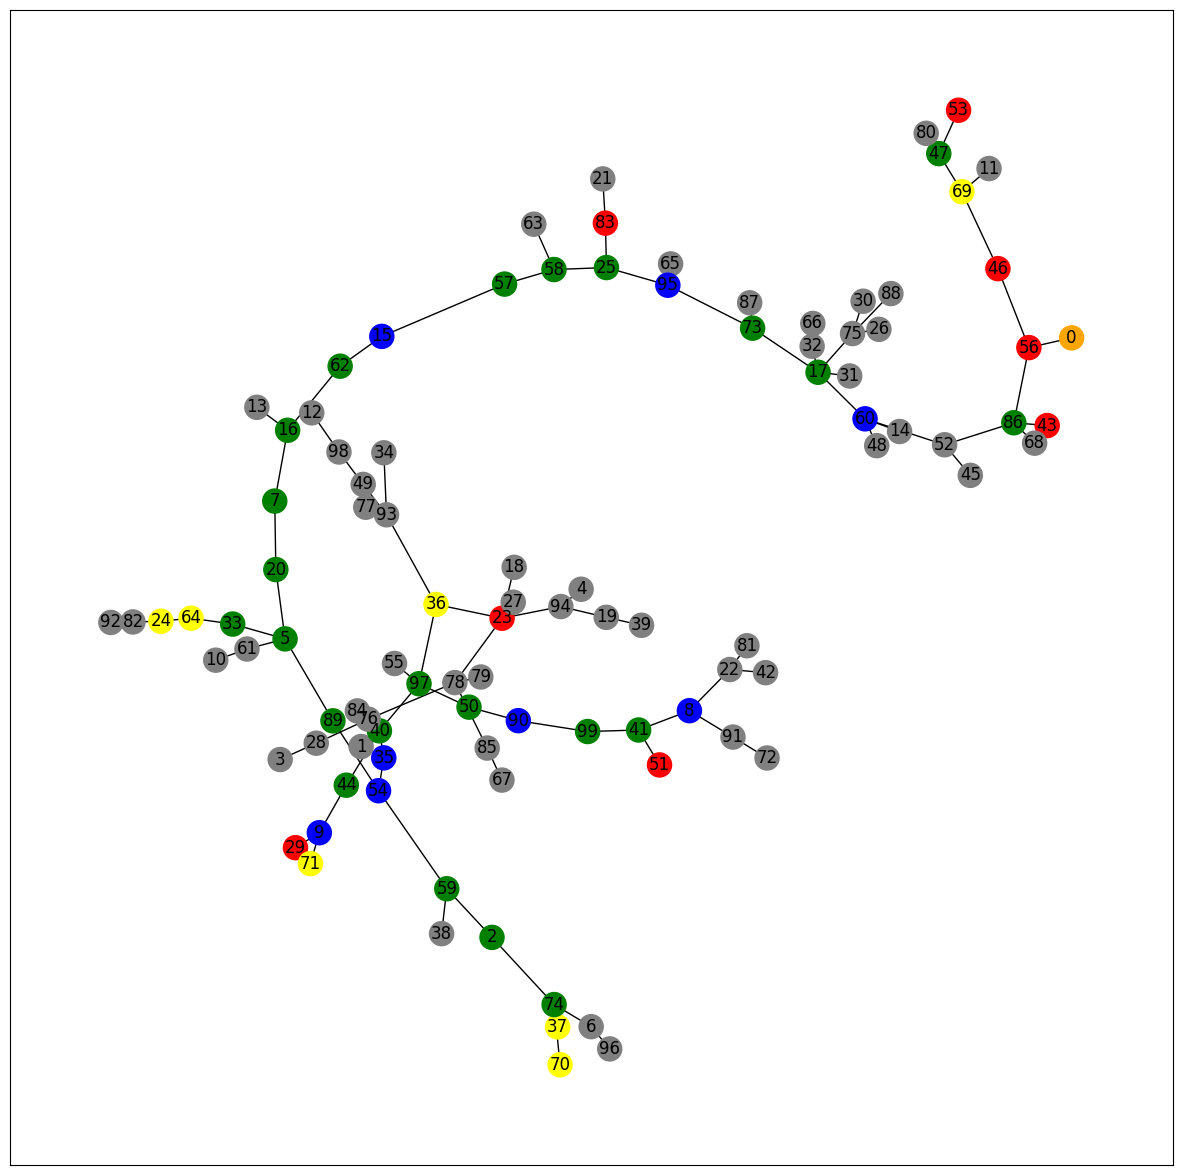

In [23]:
import networkx as nx
import utility_functions as uf

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def select_longest_flow(flows: list) -> tuple:
    '''
    Returns the flow with the longer path
    '''
    paths = uf.get_all_paths_of_all_flows(T, flows)
    max_path = max(paths, key=len)

    return [max_path[0], max_path[-1]]

def get_charging_stations_with_forward(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns the charging stations with the forward algorithm
    '''
    flow = select_longest_flow(flows)
    flows.remove(flow)

    # Set the charging stations for the first flow
    charge = L
    path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
    charging_stations = set()
    for i in range(len(path) - 1):
        charge -= Tree.edges[(path[i], path[i+1])]['weight']
        if charge < 0:
            charging_stations.add(path[i])
            charge = L
    
    # Set the charging stations for the other flows based on the existing charging stations
    charge = L
    # Order flows decreasing order
    reverse_sorted_flows = sorted(flows, reverse=True, key=lambda x: len(nx.shortest_path(T, source=x[0], target=x[1])))
    for flow in reverse_sorted_flows:
        charge = L
        path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
        for i in range(len(path) - 1):
            if path[i] in charging_stations:
                charge = L
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                charge = L
    
    return charging_stations

charging_stations = get_charging_stations_with_forward(T, flows, L)
print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)

Stesso algoritmo con la differenza che in questo caso il flusso iniziale con cui si calcola il primo set di charging station viene selezionato in base al peso del path del flow

Charging stations on nodes: {'47', '44', '59', '5', '95', '73', '33', '52', '57', '25', '97', '54', '74', '16', '40', '62', '90', '89', '99', '9', '50', '41', '2', '58', '60', '20', '8', '17', '35', '15', '75', '7', '86'}
COST: (number of charging stations): 33


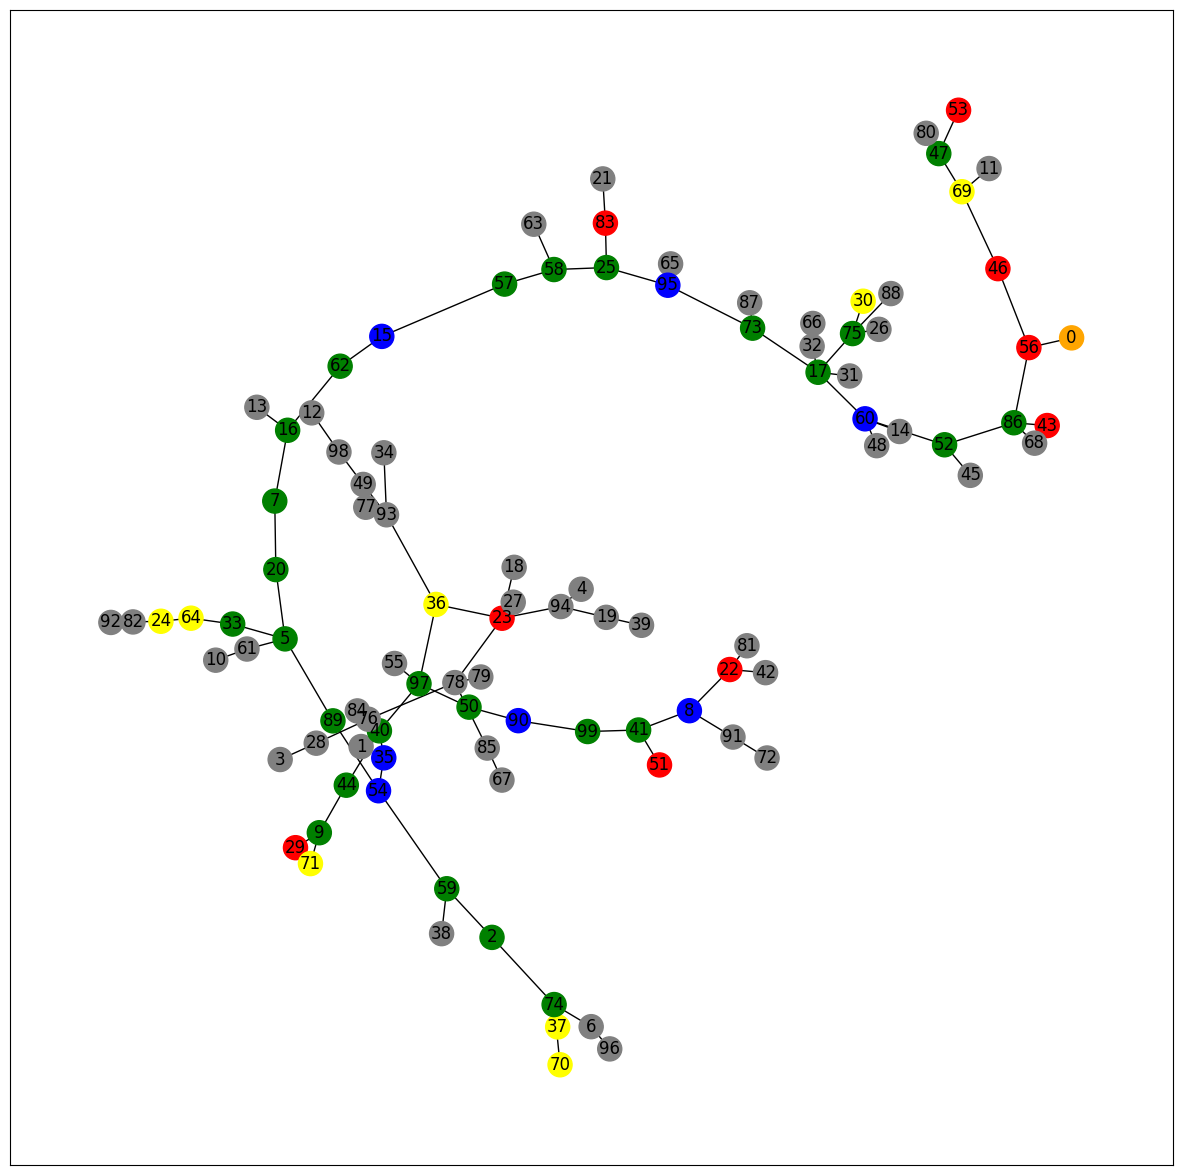

In [24]:
import networkx as nx
import utility_functions as uf

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def select_the_longest_flows_path(flows: list) -> tuple:
    '''
    Returns the flow with the longer path
    '''
    _, paths_weights = uf.get_weights(T, flows)


    return flows[paths_weights.index(max(paths_weights))]

def get_charging_stations_with_forward(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns the charging stations with the forward algorithm
    '''
    flow = select_the_longest_flows_path(flows)
    flows.remove(flow)

    # Set the charging stations for the first flow
    charge = L
    path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
    charging_stations = set()
    for i in range(len(path) - 1):
        charge -= Tree.edges[(path[i], path[i+1])]['weight']
        if charge < 0:
            charging_stations.add(path[i])
            charge = L
    
    # Set the charging stations for the other flows based on the existing charging stations
    charge = L
    # Order flows decreasing order
    reverse_sorted_flows = sorted(flows, reverse=True, key=lambda x: len(nx.shortest_path(T, source=x[0], target=x[1])))
    for flow in reverse_sorted_flows:
        charge = L
        path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
        for i in range(len(path) - 1):
            if path[i] in charging_stations:
                charge = L
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                charge = L
    
    return charging_stations

charging_stations = get_charging_stations_with_forward(T, flows, L)
print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)

### Ricerca locale 

Prova a minimizzare il numero di colonnine istanziate con la greedy forward
- Si inizializza l'insieme di stazioni di ricarica con l'algoritmo precedente
- Per ogni colonnina di ricarica, si tenta di spegnerla e si verifica se la soluzione rimane ammissibile

Così facendo, si ottiene un insieme di stazioni di ricarica che minimizza il costo e che è necessario per tutti i flussi.

Charging stations on nodes before purify: {'47', '44', '59', '5', '95', '73', '33', '57', '25', '97', '54', '74', '16', '40', '62', '90', '99', '89', '9', '50', '41', '2', '58', '60', '20', '8', '17', '35', '15', '7', '86'}
COST: (number of charging stations before the purify): 31
Charging stations on nodes after purify: {'40', '62', '99', '89', '9', '47', '50', '86', '41', '2', '58', '60', '97', '20', '73', '33', '35', '15', '7', '25', '74', '54'}
COST: (number of charging stations after the purify): 22


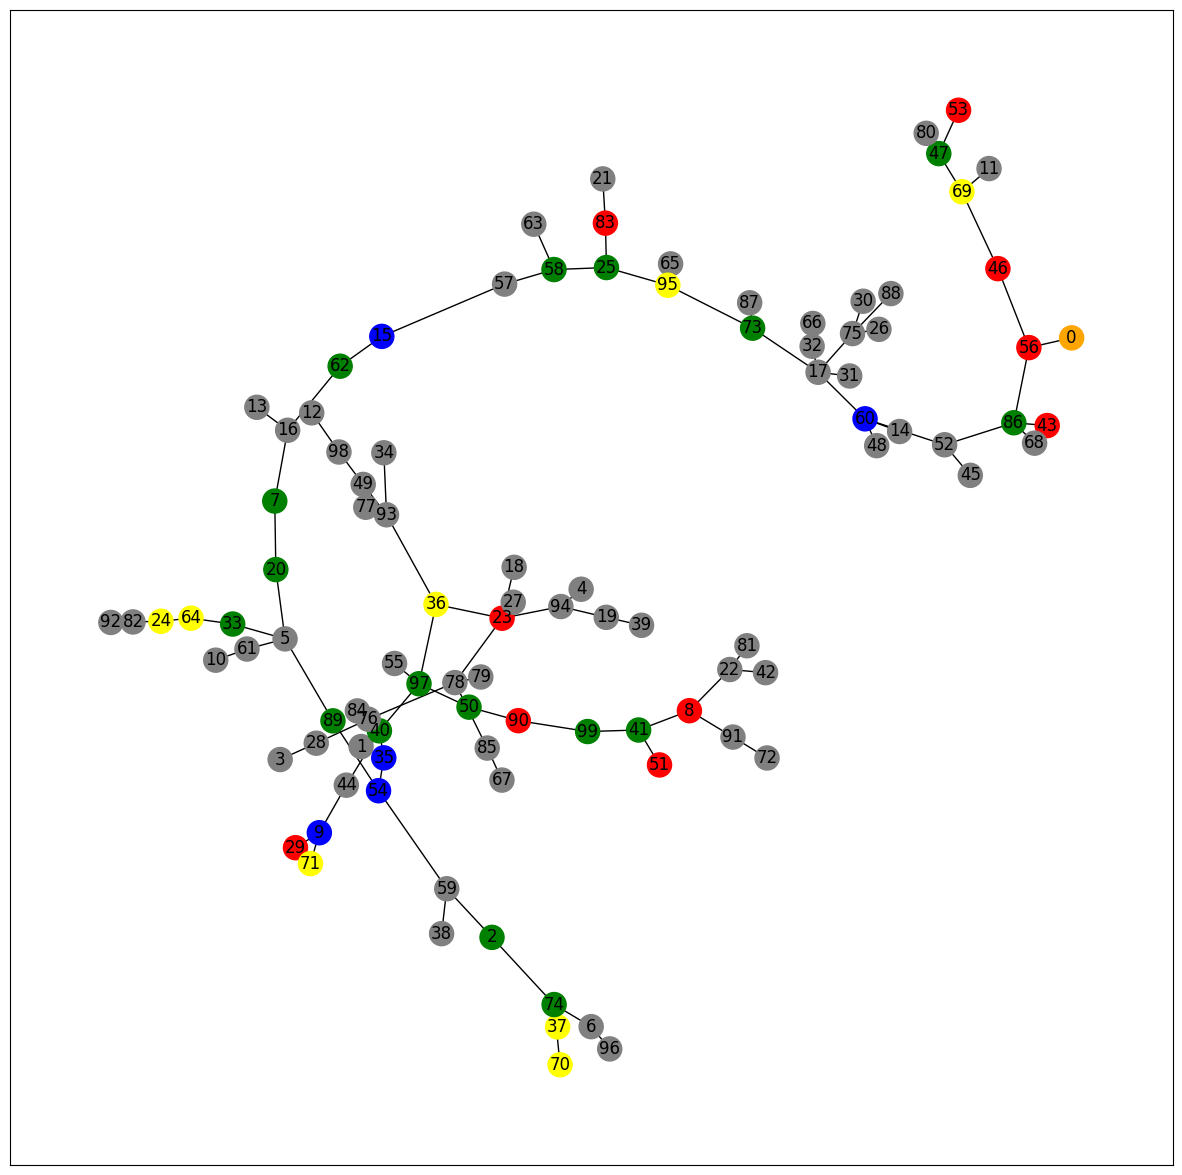

In [25]:
import networkx as nx
import utility_functions as uf

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def select_the_flow(flows: list) -> tuple:
    '''
    Select the flow that will be used to inizialize the charging stations list
    '''
    paths = uf.get_all_paths_of_all_flows(T, flows)
    max_path = max(paths, key=len)
    
    #return flows[1]
    return [max_path[0], max_path[-1]]

def get_charging_stations_with_forward(Tree: nx.Graph, flows: list):
    '''
    Set the charging stations for one forward path
    '''
    flow = select_the_flow(flows)
    flows.remove(flow)
    L = Tree.graph['L']

    # Set the charging stations for the first flow
    charge = L
    path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
    charging_stations = set()
    for i in range(len(path) - 1):
        charge -= Tree.edges[(path[i], path[i+1])]['weight']
        if charge < 0:
            charging_stations.add(path[i])
            charge = L
    
    # Set the charging stations for the other flows in base of the existing charging stations
    charge = L
    # reverse sorted flows by length of the path (number of nodes in the path)
    reverse_sorted_flows = sorted(flows, reverse=True, key=lambda x: len(nx.shortest_path(T, source=x[0], target=x[1])))
    for flow in reverse_sorted_flows:
        charge = L
        path = nx.shortest_path(Tree, source=flow[0], target=flow[1])
        for i in range(len(path) - 1):
            if path[i] in charging_stations:
                charge = L
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                charge = L
    
    return charging_stations

# provo a spegnere le stazioni di ricarica e testare se i veicoli riescono a raggiungere la destinazione
def purify_charging_stations(Tree: nx.Graph, charging_stations: set, flows: list):
    L = Tree.graph['L']
    Copy_tree = Tree.copy()
    uf.set_chrg_stations(Copy_tree, list(charging_stations))
    real_charging_stations = set()
    real_charging_stations = charging_stations.copy()
    for node in charging_stations:
        Copy_tree.nodes[node]['chrg_station'] = False
        if not uf.is_admissible(Copy_tree, flows, L):
            Copy_tree.nodes[node]['chrg_station'] = True
        else:
            real_charging_stations.remove(node)
    
    return real_charging_stations

        

charging_stations = get_charging_stations_with_forward(T, flows)
print("Charging stations on nodes before purify:", (charging_stations))
print(f"COST: (number of charging stations before the purify): {len(charging_stations)}")

# now I try to remove the charging stations that are not necessary
charging_stations = purify_charging_stations(T, charging_stations, flows)
print("Charging stations on nodes after purify:", (charging_stations))
print(f"COST: (number of charging stations after the purify): {len(charging_stations)}")

uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)


Creare una matrice dei pesi dove si da un peso ad ogni nodo che dipende dal numero di path che lo percorre. Poi per ogni path dare un peso che dipdende dalla somma dei pesi dei nodi del path. Poi in base a questo utilizzare la matrice come info per decidere dove mettere le colonnine.

In [26]:
import networkx as nx
import utility_functions as uf
import numpy as np

# READING THE TREE NETWORK FROM THE .gml FILE 
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")




nodes_weights, paths_weights = uf.get_weights(T, flows)
print("Weights of the nodes:", nodes_weights)
print("Weights of the paths:", paths_weights)

print(max(paths_weights))
print(flows[paths_weights.index(max(paths_weights))])





Weights of the nodes: [2, 0, 3, 0, 0, 7, 0, 6, 2, 3, 0, 0, 0, 0, 0, 7, 6, 8, 0, 0, 6, 0, 1, 1, 1, 8, 0, 0, 0, 1, 1, 0, 0, 2, 0, 7, 2, 2, 0, 0, 7, 3, 0, 1, 3, 0, 1, 1, 0, 0, 4, 1, 6, 1, 8, 0, 5, 7, 7, 3, 7, 0, 6, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 8, 3, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 6, 4, 0, 0, 0, 0, 8, 0, 5, 0, 3]
Weights of the paths: [3, 142, 60, 41, 23, 59, 97, 21, 136, 46, 134, 118, 60, 49, 113]
142
['56', '9']
